In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Stochastic Differential Equation
$$dX_t=\mu(t,X_t)dt+\sigma(t,X_t)dB_t$$
The general Euler scheme start with $t=t_0$ and $X_0=x_0$. For each $k=1,...,\lfloor T/h \rfloor$ we generate a gaussian white noise $\xi\sim\mathcal{N}(0,1)$ and compute the next iteration $X_k=X_{k-1}+\mu(kh,X_{k-1})h+\sigma(kh,X_{k-1})\sqrt{h}\xi$.

In [2]:
def SDE_solver(x0 : float, t0 : float, T : float, dt : float,  mu : callable, sigma : callable) -> np.array:
    """
    Solve the SDE dx = mu(t, x) dt + sigma(t, x) dB
    with x(t0) = x0, for t0 <= t <= T, with time step dt
    """
    N = int((T-t0)/dt)
    X = np.zeros(N, dtype=float)
    X[0] = x0
    for i in range(1, N):
        X[i] = X[i-1] + mu(i*dt, X[i-1]) * dt + sigma(i*dt,  X[i-1]) * np.sqrt(dt) * np.random.randn()
    return X


### Ornstein–Uhlenbeck process
$$dx=-\mu x dt + \sigma dB$$
The general stochastic process when $\mu(x,t)=-\mu x$ and $\sigma(x,t)=\sigma$. The more general expression has $\mu(x,t)=\theta(\mu - x)$.

The deterministic process is when $dx=-\mu x dt$, so $x(t)=x_0e^{-\mu(t-t0)}$

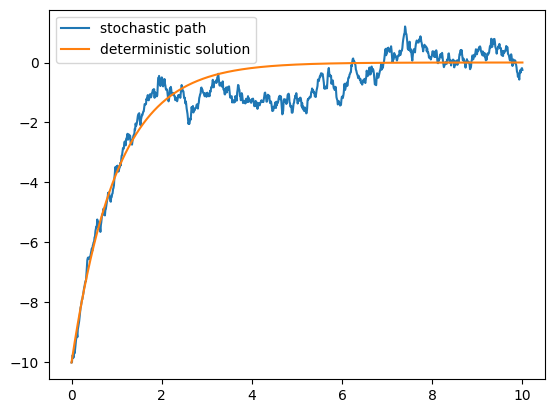

In [3]:
mu = lambda t, x : -1.0 * x
sigma = lambda t, x : 1.0

X = SDE_solver(x0=-10.0, t0=0.0, T=10.0, dt=0.01, mu=mu, sigma=sigma)
t = np.linspace(0, 10.0, len(X))


plt.plot(t, X, label='stochastic path')
plt.plot(t, -10*np.exp(-1.0*t), label='deterministic solution')
plt.legend()
plt.show()

### Adding jump process
$$dX_t=\mu(t,X_t)dt+\sigma(t,X_t)dB_t+J(t,X_t,Z)dN_t$$
$dN$ is a poisson process and it's independent on $dB$. $J$ is the jump size and can depend on $x$, $t$ and a new random variable $Z$ which represent the magnitude of the jump (could be a normal distribution).

In [4]:
def SDE_with_jump(x0 : float, t0 : float, T : float, dt : float,  mu : callable, sigma : callable, l : float, J : callable) -> tuple:
    """
    Solve the SDE with jump dx = mu(t, x) dt + sigma(t, x) dB + J(t, x) dN
    with x(t0) = x0, for t0 <= t <= T, with time step dt
    lambda is average number of jumps per unit time dt and J is the jump size
    """
    N = int((T-t0)/dt)
    X = np.zeros(N, dtype=float)
    jumps = []
    X[0] = x0
    for i in range(1, N):
        t = i*dt
        jump_happens = np.random.uniform(0, 1) < l * dt
        dN = J(t, X[i-1]) if jump_happens else 0
        X[i] = X[i-1] + mu(t, X[i-1]) * dt + sigma(t,  X[i-1]) * np.sqrt(dt) * np.random.randn() + dN
        jumps.append([t, dN]) if jump_happens else None
    return (X, jumps)

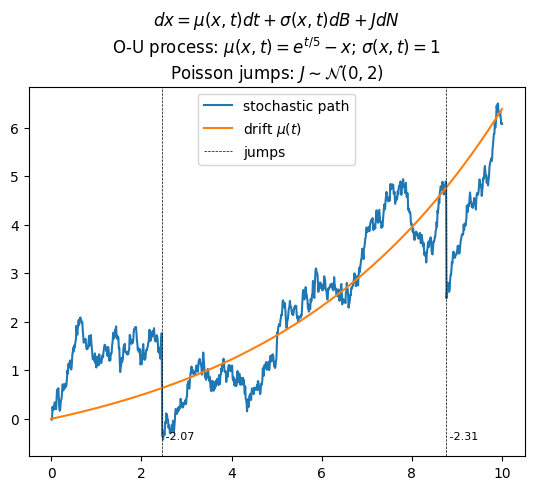

In [10]:
# exponential drift and Ornstein-Uhlenbeck process with normal jumps
mu = lambda t, x :  np.exp(t/5) - 1.0 * x
sigma = lambda t, x : 1.0
J = lambda t, x : np.random.normal(0, 2)

X, jumps = SDE_with_jump(x0=0.0, t0=0.0, T=10.0, dt=0.01, mu=mu, sigma=sigma, l=0.2, J=J)
t = np.linspace(0, 10.0, len(X))

plt.plot(t, X)
plt.plot(t, np.exp(t/5) -1)
for j in jumps:
    plt.axvline(x=j[0], color='k', linestyle='--', linewidth=0.5)
    plt.text(j[0], min(X), f' {j[1]:+.2f}', fontsize=8)
plt.legend(['stochastic path', 'drift $\\mu(t)$', 'jumps'])
plt.title('$dx=\\mu(x,t)dt+\\sigma(x,t)dB+JdN$\nO-U process: $\\mu(x,t)=e^{t/5}-x$; $\\sigma(x,t)=1$\nPoisson jumps: $J\\sim\\mathcal{N}(0, 2)$')
plt.show()

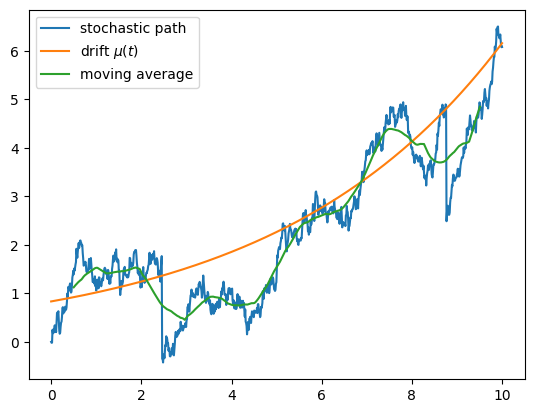

In [11]:
def mooving_average(x : np.array, n : int) -> np.array:
    """
    Compute the moving average of x with window size n
    """
    return np.convolve(x, np.ones(n), 'valid') / n

def mooving_variance(x : np.array, n : int) -> np.array:
    """
    Compute the moving variance of x with window size n
    """
    return np.convolve(x**2, np.ones(n), 'valid') / n - mooving_average(x, n)**2

average = mooving_average(X, 100)
variance = mooving_variance(X, 100)

plt.plot(t, X, label='stochastic path')
plt.plot(t, np.exp(t/5) * 5 / 6, label='drift $\\mu(t)$')
plt.plot(t[50:-49], average, label='moving average')
plt.legend()
plt.show()